In [ ]:
  !kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
diabetes-health-indicators-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/diabetes-health-indicators-dataset.zip -d /content/diabetes-health-indicators-dataset

Archive:  /content/diabetes-health-indicators-dataset.zip
replace /content/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# import thư viện và đọc, lọc và phân chia dữ liệu từ file csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

In [ ]:
features = pd.read_csv('/content/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Preprocessing

In [ ]:
# gộp
features.loc[features['Education'] < 3, 'Education'] = 3

In [ ]:
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)

In [ ]:
# loại bỏ các dữ liệu trùng lặp
Sscaler = StandardScaler()
Rscaler = RobustScaler()
Mscaler = MinMaxScaler()
features_standardized = pd.DataFrame(Sscaler.fit_transform(features), columns=features.columns)
features_robust = pd.DataFrame(Rscaler.fit_transform(features), columns=features.columns)
features_MinMax = pd.DataFrame(Mscaler.fit_transform(features), columns=features.columns)



features[['BMI', 'Age', 'GenHlth']] = features_standardized[['BMI', 'Age', 'GenHlth']]
features[['MentHlth', 'PhysHlth']] = features_robust[['MentHlth', 'PhysHlth']]
features[['Education', 'Income']] = features_MinMax[['Education', 'Income']]

In [ ]:
features

# Sử dụng gridSearchCV tìm tham số tốt nhất

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
estimator = DecisionTreeClassifier(criterion='gini', max_depth=9, min_impurity_decrease=0.00011, random_state=42, splitter='best')
adaboost = AdaBoostClassifier(estimator=estimator,learning_rate=0.075, n_estimators=30, random_state=42)
adaboost.fit(X=x_train, y=y_train)

y_pred = adaboost.predict(X=x_val)
y_pred_on_train = adaboost.predict(X=x_train)
print(f1_score(y_val, y_pred, average='macro'))
print(f1_score(y_train, y_pred_on_train, average='macro'))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.744890202613955
0.7566150417746703


In [ ]:
estimator = DecisionTreeClassifier(criterion='gini', max_depth=9, min_impurity_decrease=0.00011, random_state=42, splitter='best')
param_grid = {
    'estimator':[estimator],
    'learning_rate':np.arange(start=0.01, stop=0.2, step=0.01),
    'n_estimators':np.arange(start=71, stop=80, step=1),
    'random_state':[42]
}

model = AdaBoostClassifier()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
optimal = grid_search.best_params_

Fitting 5 folds for each of 171 candidates, totalling 855 fits


KeyboardInterrupt: 

# Khảo sát mức độ quan trọng của thuộc tính

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
estimator = DecisionTreeClassifier(criterion='gini',min_impurity_decrease=0.00011, max_depth=9, random_state=42, splitter='best')
adaboost = AdaBoostClassifier(estimator=estimator,learning_rate=0.15, n_estimators=41, random_state=42)
adaboost.fit(X=x_train, y=y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_impurity_decrease=0.00011,
                                                    random_state=42),
                   learning_rate=0.15, n_estimators=41, random_state=42)

In [ ]:
featureColumn = []
means = []
std = []
perm_importance = permutation_importance(estimator=adaboost, X=x_val, y=y_val, scoring='f1_macro', n_repeats=50, random_state=42)
for i in perm_importance.importances_mean.argsort()[::-1]:
    featureColumn.append(features.columns[i+1])
    means.append(perm_importance.importances_mean[i])
    std.append(perm_importance.importances_std[i])

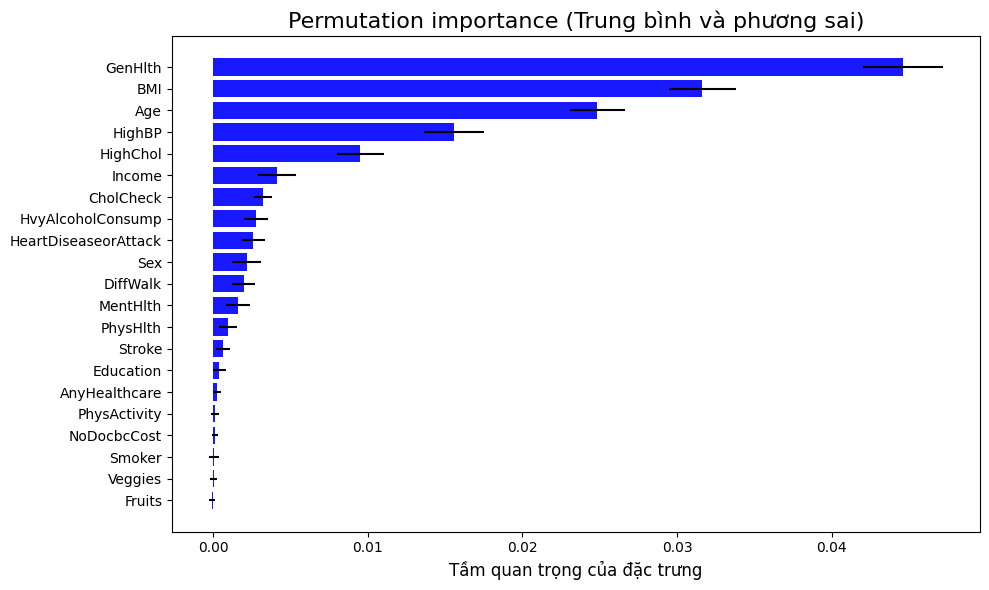

In [ ]:
sorted_indices = np.argsort(means)[::-1]
features_sorted = [featureColumn[i] for i in sorted_indices]
importance_sorted = [means[i] for i in sorted_indices]
std_sorted = [std[i] for i in sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, importance_sorted, xerr=std_sorted, color='blue', alpha=0.9)
plt.gca().invert_yaxis()  # Đảo ngược trục y để giá trị cao nhất ở trên cùng
plt.title("Permutation importance (Trung bình và phương sai)", fontsize=16)
plt.xlabel("Tầm quan trọng của đặc trưng", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
res = permutation_importance(estimator=adaboost, X=x_val, y=y_val, scoring='f1_macro', n_repeats=50, random_state=42)
columns = features.columns.drop(labels='Diabetes_binary')
result = pd.DataFrame({'Name': columns, 'importances_mean': res.importances_mean, 'importances_std': res.importances_std})
result.sort_values(by='importances_mean', ascending=False, inplace=True)
print(result)

                    Name  importances_mean  importances_std
13               GenHlth          0.044610         0.002610
3                    BMI          0.031647         0.002190
18                   Age          0.024855         0.001763
0                 HighBP          0.015570         0.001963
1               HighChol          0.009527         0.001507
20                Income          0.004128         0.001218
2              CholCheck          0.003219         0.000576
10     HvyAlcoholConsump          0.002769         0.000793
6   HeartDiseaseorAttack          0.002604         0.000768
17                   Sex          0.002165         0.000941
16              DiffWalk          0.001977         0.000749
14              MentHlth          0.001627         0.000776
15              PhysHlth          0.000964         0.000606
5                 Stroke          0.000647         0.000433
19             Education          0.000403         0.000435
11         AnyHealthcare          0.0002

In [ ]:
columns = list(result.Name[0:19])
columns.append('Diabetes_binary')
print(len(columns))

20


# Xây dựng tại tập train | test

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0][columns]
class_1 = features[features['Diabetes_binary'] == 1][columns]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
estimator = DecisionTreeClassifier(criterion='gini',min_impurity_decrease=0.00011, max_depth=9, random_state=42, splitter='best')
adaboost = AdaBoostClassifier(estimator=estimator,learning_rate=0.15, n_estimators=41, random_state=42)
adaboost.fit(X=x_train, y=y_train)

y_pred = adaboost.predict(X=x_test)
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_true=y_test, y_pred=y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.755835949397779
0.7567156614292955


In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
estimator = DecisionTreeClassifier(criterion='gini',min_impurity_decrease=0.00011, max_depth=9, random_state=42, splitter='best')
adaboost = AdaBoostClassifier(estimator=estimator,learning_rate=0.15, n_estimators=41, random_state=42)
adaboost.fit(X=x_train, y=y_train)

y_pred = adaboost.predict(X=x_test)
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_true=y_test, y_pred=y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7561603274767402
0.7570052856418796
